# Clustering IRIS over Income Distribution

## Import

In [21]:
%pip install openpyxl   # for pd.read_excel
%pip install ipywidgets # for tqdm.notebook
%pip install pot        # for ot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import ot
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import geopandas as gpd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import sys
sys.path.append("..")

from src import (
    bary_WKMeans_1d,
)

In [23]:
# Load income deciles dataset
df = pd.read_csv('../data/BASE_TD_FILO_DEC_IRIS_2020.csv', sep=';', decimal=',')

decile_cols = ['DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_MED20', 'DEC_D620', 'DEC_D720', 'DEC_D820', 'DEC_D920']

# Convert from object to float64
df[decile_cols] = df[decile_cols].apply(pd.to_numeric, errors='coerce')

# Drop the 1319 rows with missing deciles
df_clean = df.dropna(subset=decile_cols).reset_index(drop=True)

distributions = df_clean[decile_cols].to_numpy()

# this line is useful if we want to focus more on the heterogeneity between iris :
# distributions = distributions_raw / distributions_raw.sum(axis=1, keepdims=True)

# Useful 
support = np.arange(1, 10)  # D1 to D9
colors = ['cornflowerblue', 'forestgreen', 'red', 'deeppink', 'orange', 'brown', 'purple']
n_distributions = distributions.shape[0]


Data preview:
        IRIS DEC_PIMP20 DEC_TP6020 DEC_Q120  DEC_MED20 DEC_Q320 DEC_EQ20  \
0  010040101       41,8       32,7    10940    18240.0    24950     0,77   
1  010040102       39,0       41,1     9010    15860.0    23660     0,92   
2  010040201       45,6       29,2    11700    19130.0    27000     0,80   
3  010040202       59,8       14,0    17500    24790.0    33710     0,65   
4  010330102       39,1       30,6    11100    19090.0    29590     0,97   

   DEC_D120  DEC_D220  DEC_D320  ...  DEC_RD20  DEC_S80S2020  DEC_GI20  \
0    6220.0    9630.0   12440.0  ...       5,3           6,8     0,328   
1    4030.0    7750.0   10150.0  ...       7,8           9,7     0,370   
2    6150.0   10030.0   13260.0  ...       5,7           7,6     0,342   
3   10820.0   15850.0   19050.0  ...       4,1           5,5     0,317   
4    4930.0    9220.0   12910.0  ...       8,6          10,7     0,391   

   DEC_PACT20  DEC_PTSA20 DEC_PCHO20 DEC_PBEN20 DEC_PPEN20 DEC_PAUT20  \
0        68

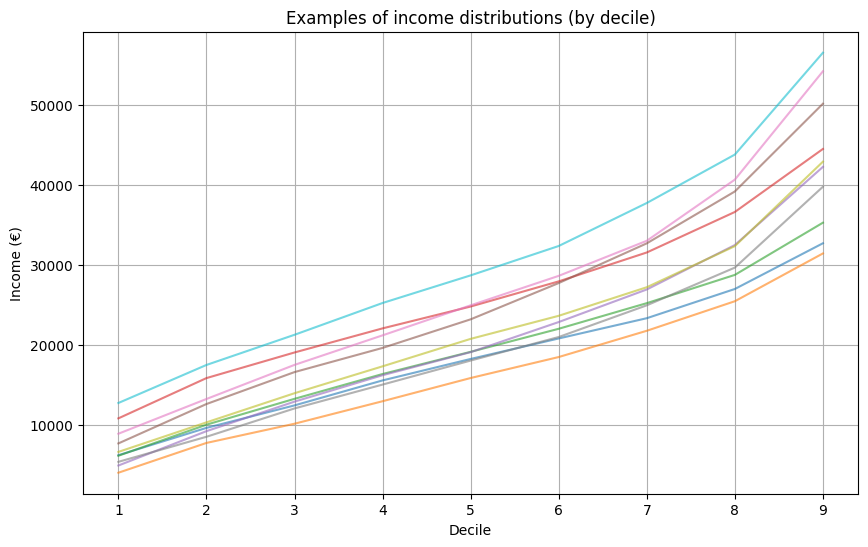

In [24]:
# Overview of the data

print("Data preview:")
print(df_clean.head())

print("\nGeneral information:")
print(df_clean.info())

print("\nDescriptive statistics:")
print(df_clean.describe())

# Plot of few IRIS deciles
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(support, df_clean.loc[i, decile_cols], alpha=0.6)
plt.title("Examples of income distributions (by decile)")
plt.xlabel("Decile")
plt.ylabel("Income (€)")
plt.grid(True)
plt.show()


## Barycenters with Wasserstein

### Elbow Method

We use the elbow method to determine a suitable number of clusters for our data.

The elbow method consists in computing the clustering cost (typically the within-cluster sum of squared distances) for different values of k and identifying the point beyond which adding more clusters yields diminishing returns.

In [25]:
k_values = range(1, 11)

inertias = []
for k_test in tqdm(k_values):
    assignments, barycenters = bary_WKMeans_1d(distributions, support, k_test, n_iter=20)
    inertia = 0
    for i in range(n_distributions):
        bary = barycenters[assignments[i]]
        inertia += ot.wasserstein_1d(support, support, distributions[i], bary)
    inertias.append(inertia)


  0%|          | 0/10 [00:00<?, ?it/s]

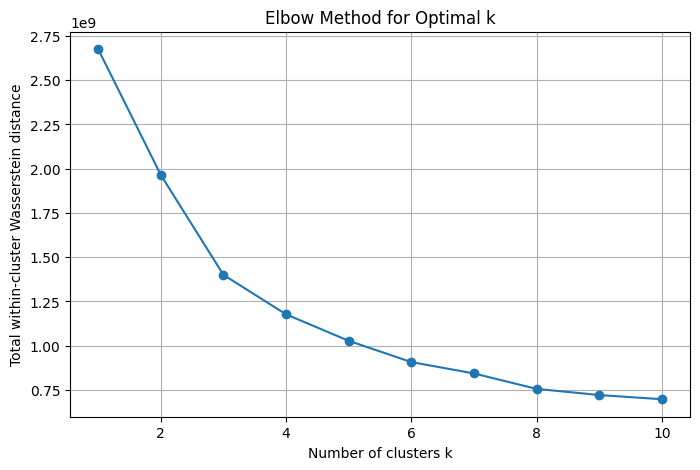

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters k")
plt.ylabel("Total within-cluster Wasserstein distance")
plt.grid(True)
plt.show()


We observe a rapid decrease in the total within-cluster Wasserstein distance between *k* = 1 and *k* = 3.

From *k* = 4 onward, the curve appears to flatten. The classic elbow seems to be located around *k* = 3

### Barycenters plot

In this section, we apply the barycenter-based clustering algorithm using k=3 and visualize the resulting clusters.

In [27]:
k = 3

assignments, barycenters = bary_WKMeans_1d(distributions, support, k, n_iter=20)
df_clean["cluster_wasserstein_1d"] = assignments

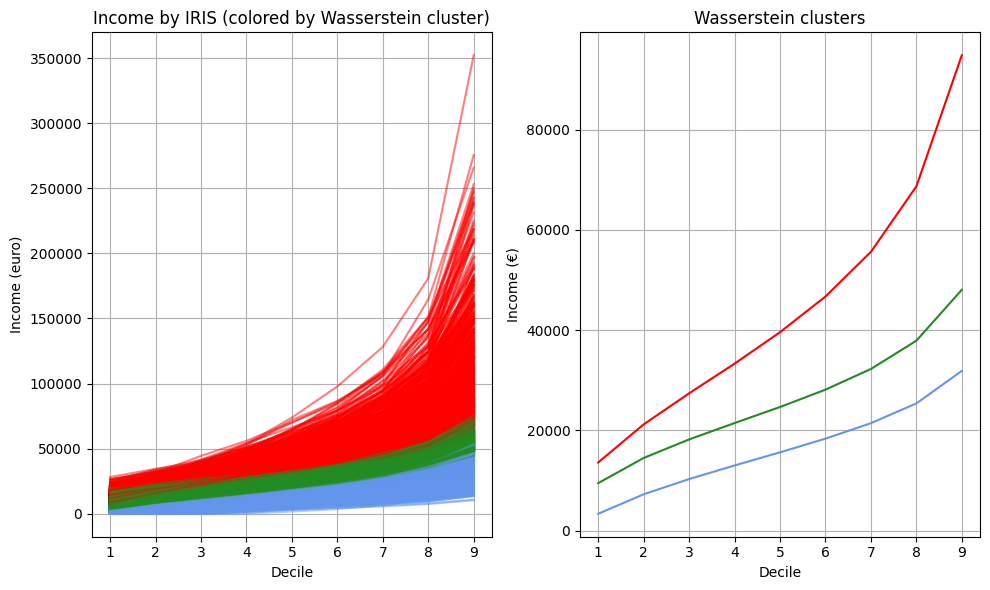

In [28]:
plt.figure(figsize=(10, 6))

# Plot all distributions 
plt.subplot(1, 2, 1)
for i in range(n_distributions):
    cluster = assignments[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)

plt.title("Income by IRIS (colored by Wasserstein cluster)")
plt.xlabel("Decile")
plt.ylabel("Income (euro)")
plt.grid(True)

# Plot Barycenters
plt.subplot(1, 2, 2)
for i in range(len(barycenters)):
    plt.plot(support, barycenters[i], color=colors[i % len(colors)])
plt.title("Wasserstein clusters")
plt.xlabel("Decile")
plt.ylabel("Income (€)")
plt.grid(True)

plt.tight_layout()
plt.show()


### PCA Projection

To better understand the structure of the clusters in a lower-dimensional space, we project the data onto its two first principal components using Principal Component Analysis (PCA).

This allows us to visualize the clusters in 2D while preserving as much variance from the original data as possible. If the clustering captures meaningful patterns, we expect to see well-separated groups in this projection.

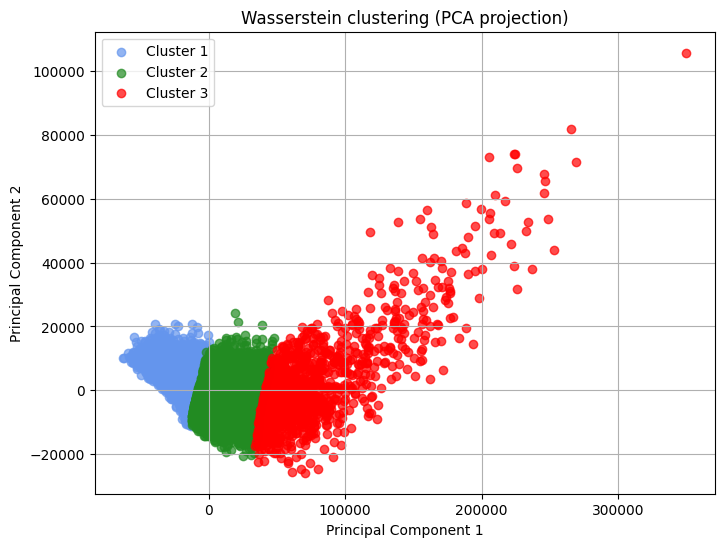

In [29]:
pca = PCA(n_components=2)
proj = pca.fit_transform(distributions)

plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(proj[assignments == i, 0], proj[assignments == i, 1], color=colors[i], label=f'Cluster {i+1}', alpha=0.7)

plt.title("Wasserstein clustering (PCA projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In the projection, we can see that the clusters are well separated and appear convex in the 2D space spanned by the first two principal components. This visual clarity suggests that these components capture meaningful variation in the income distribution shapes.

To better understand what these components represent, we now inspect the explained variance ratio, to quantify how much of the overall variability is preserved in the 2D PCA projection.

In [30]:
loadings = pd.DataFrame(pca.components_.T,
                        index=decile_cols,
                        columns=["PC1", "PC2"])

print(loadings)

print("\n Explained variance ratio:")
print(pca.explained_variance_ratio_)


                PC1       PC2
DEC_D120   0.101160 -0.402866
DEC_D220   0.139276 -0.418383
DEC_D320   0.171548 -0.388199
DEC_D420   0.204798 -0.339027
DEC_MED20  0.242521 -0.273063
DEC_D620   0.287614 -0.192719
DEC_D720   0.348558 -0.083381
DEC_D820   0.445607  0.095626
DEC_D920   0.661363  0.518861

 Explained variance ratio:
[0.94339096 0.05097913]


PC1 captures an overall income level i.e. IRIS with higher values in higher deciles (especially D9) will have a higher PC1 score. It is a sort of wealth index.

While PC2 contrasts lower deciles (D1–D4) with upper deciles (D8–D9). Thus PC2 reflects the income inequality or skewness of the distribution.

Moreover, the explained variance ratio shows that PC1 explains about 94% of the variance, while PC2 only explains about 5%. This means most of the variability in the data is along the first component, confirming that overall income level is the dominant factor differentiating clusters.

## Comparison with a K-Means based on the median

To assess the added value of using full income distributions and Wasserstein distances, we compare our clustering results to a simpler K-Means approach applied directly to the median income of each IRIS unit. Since the median summarizes the central tendency of the distribution, this comparison will help us understand whether it is sufficient for capturing the main differences in income profiles.

In [31]:
# Computation
kmeans_median = KMeans(n_clusters=k, n_init="auto", random_state=0)
df_clean["cluster_median"] = kmeans_median.fit_predict(df_clean[["DEC_MED20"]])


### Clustering Comparison

In this first comparison, we plot all IRIS units in the plane and color them by cluster — once for the Wasserstein-based clustering and once for the median-based K-Means. The clusters appear remarkably similar, suggesting that most of the variability is already captured by the median alone.

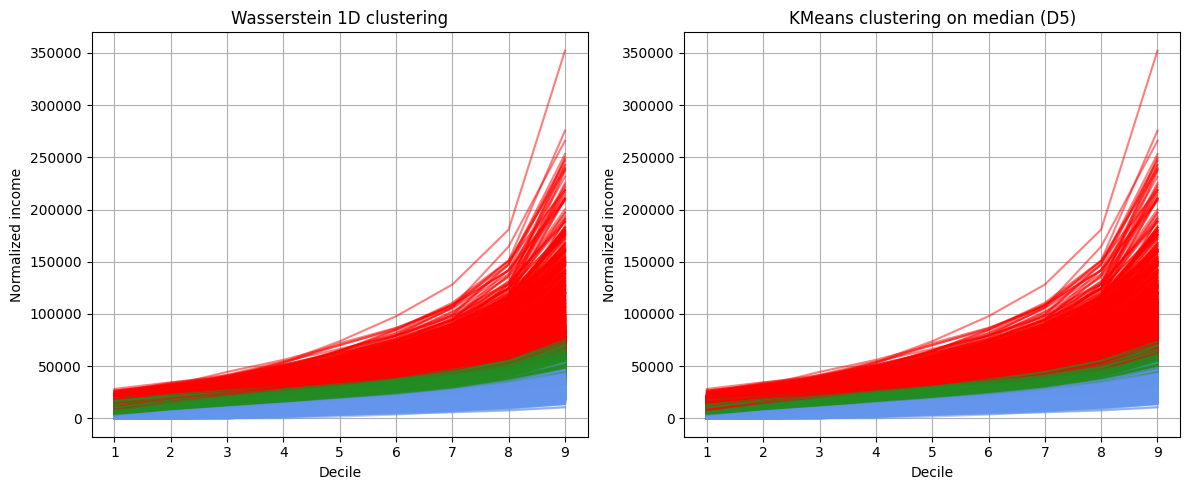

In [32]:
# Clustering Comparison

plt.figure(figsize=(12, 5))

# Wasserstein clustering
plt.subplot(1, 2, 1)
for i in range(n_distributions):
    cluster = assignments[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)
plt.title("Wasserstein 1D clustering")
plt.xlabel("Decile")
plt.ylabel("Normalized income")
plt.grid(True)

# KMeans on median
plt.subplot(1, 2, 2)
for i in range(n_distributions):
    cluster = df_clean["cluster_median"].iloc[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)
plt.title("KMeans clustering on median (D5)")
plt.xlabel("Decile")
plt.ylabel("Normalized income")
plt.grid(True)

plt.tight_layout()
plt.show()


### Clusters Comparison

We then visualize each cluster individually for both methods. This more granular view confirms the close similarity between the two approaches, with only minor differences at the margins.

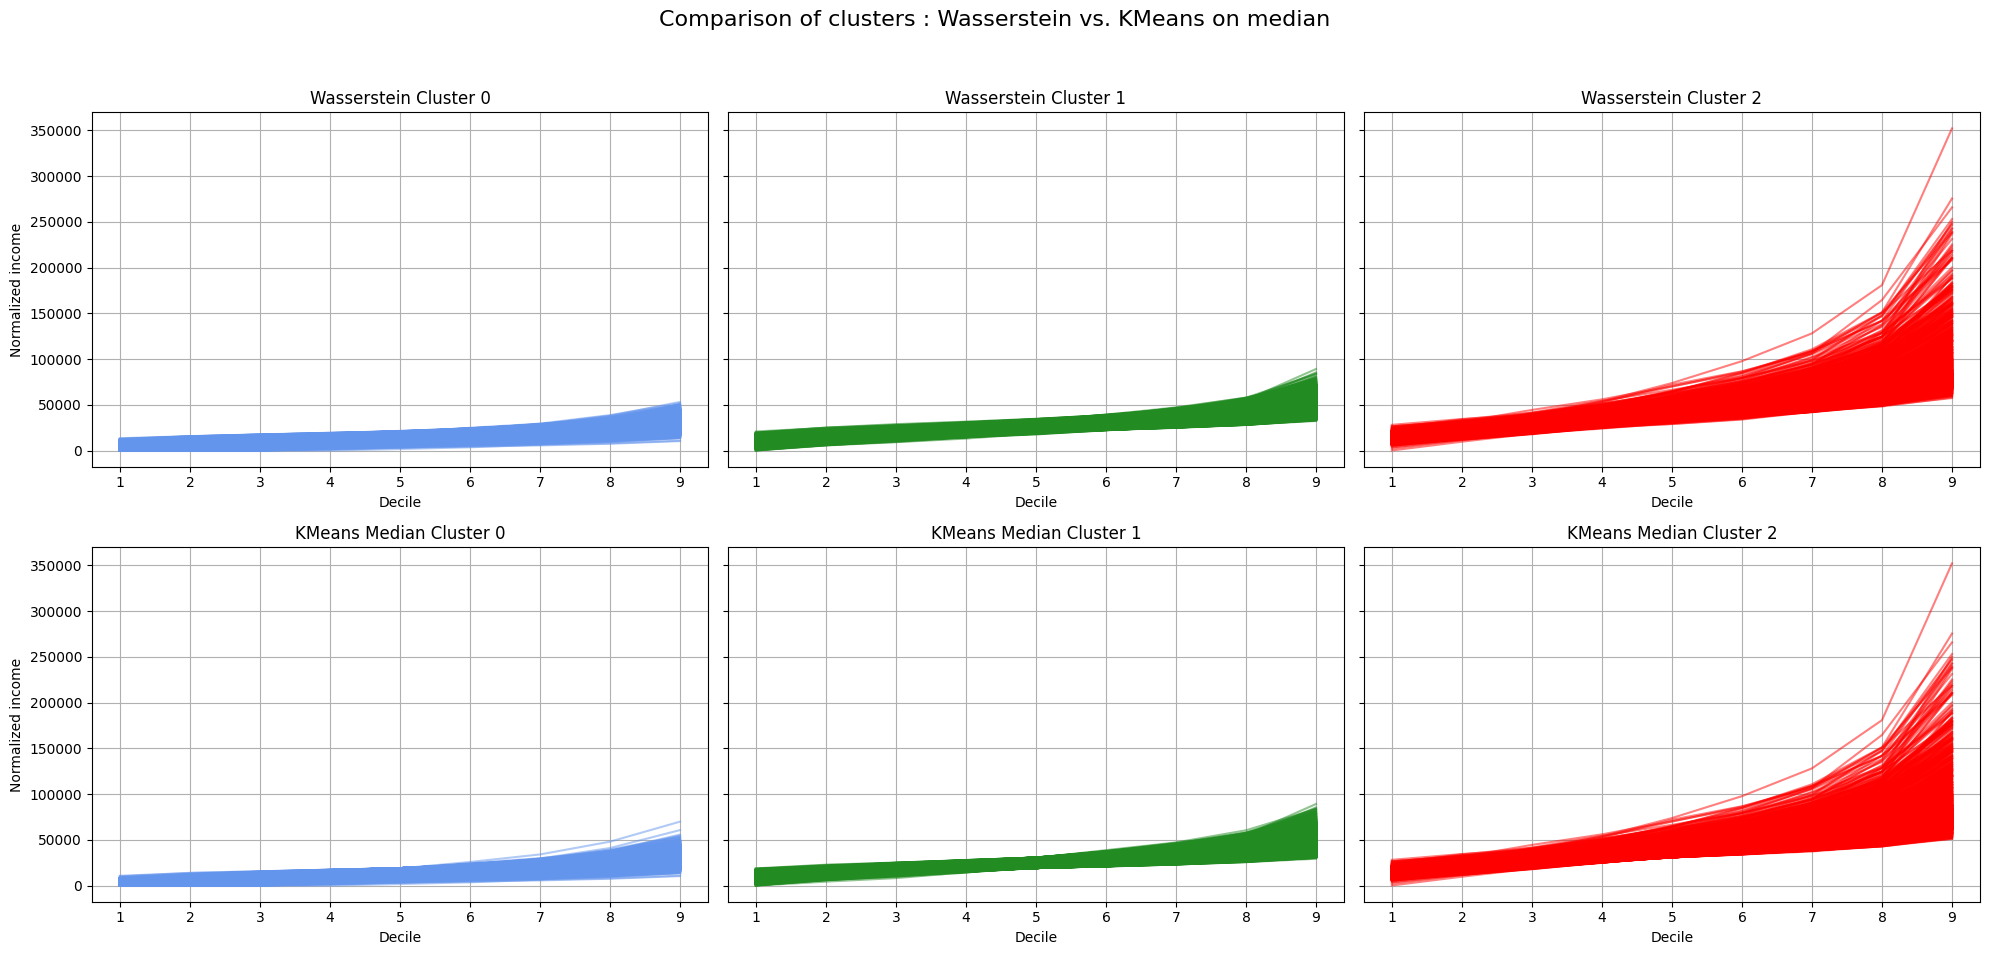

In [33]:
# Clusters Comparison

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
fig.suptitle("Comparison of clusters : Wasserstein vs. KMeans on median", fontsize=16)

# Wasserstein clusters
for cluster_id in range(k):
    ax = axes[0, cluster_id]
    members = distributions[df_clean["cluster_wasserstein_1d"] == cluster_id]
    for dist in members:
        ax.plot(support, dist, color=colors[cluster_id % len(colors)], alpha=0.5)
    ax.set_title(f"Wasserstein Cluster {cluster_id}")
    ax.set_xlabel("Decile")
    if cluster_id == 0:
        ax.set_ylabel("Normalized income")
    ax.grid(True)

# KMeans on median clusters
for cluster_id in range(k):
    ax = axes[1, cluster_id]
    members = distributions[df_clean["cluster_median"] == cluster_id]
    for dist in members:
        ax.plot(support, dist, color=colors[cluster_id % len(colors)], alpha=0.5)
    ax.set_title(f"KMeans Median Cluster {cluster_id}")
    ax.set_xlabel("Decile")
    if cluster_id == 0:
        ax.set_ylabel("Normalized income")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### PCA Comparison

Finally, we project both clustering results into the PCA space to assess their separation visually. The clusters remain well-separated and largely overlapping, reinforcing the idea that the first principal component — which is strongly correlated with income level — drives most of the clustering structure.

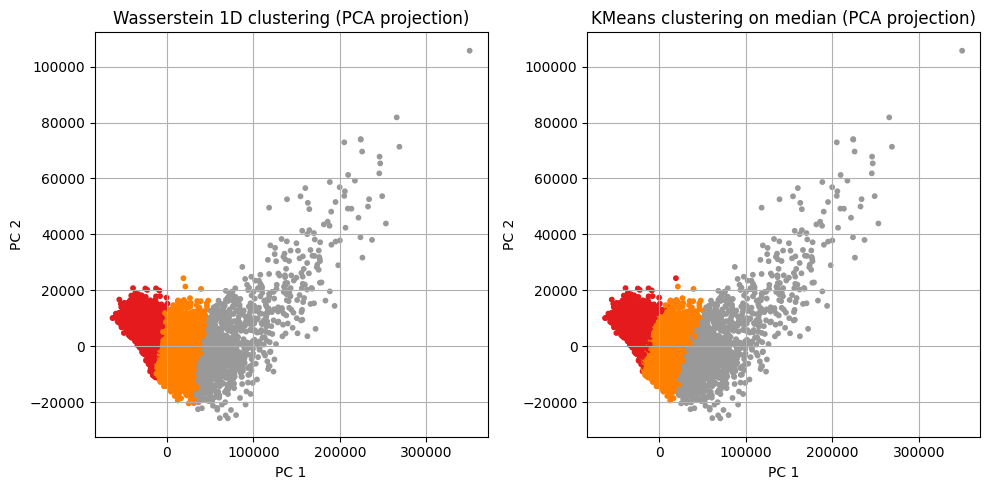

In [34]:
# PCA Comparison

plt.figure(figsize=(10, 5))

# Wasserstein
plt.subplot(1, 2, 1)
plt.scatter(proj[:, 0], proj[:, 1], c=df_clean["cluster_wasserstein_1d"], cmap="Set1", s=10)
plt.title("Wasserstein 1D clustering (PCA projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)

# KMeans on median
plt.subplot(1, 2, 2)
plt.scatter(proj[:, 0], proj[:, 1], c=df_clean["cluster_median"], cmap="Set1", s=10)
plt.title("KMeans clustering on median (PCA projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)

plt.tight_layout()
plt.show()


We observe that the two projections are very similar. If we had to note any differences, the Wasserstein clustering tends to produce convex clusters, which is not perfectly the case for standard K-means. Additionally, cluster 3 in the Wasserstein K-means appears slightly smaller than in standard K-means, resulting in slightly larger clusters 1 and 2.

## Mapping

In this section, we visualize the spatial distribution of our clusters. Mapping allows us to better understand the geographical patterns and differences between the clusters identified by our analysis. We will start with a national scale overview before zooming into a regional scale for more detailed insights.

In [35]:
# Load IRIS boundaries
gdf = gpd.read_file("../data/contours-iris.gpkg")

gdf["code_iris"] = gdf["code_iris"].astype(str)
df_clean["IRIS"] = df_clean["IRIS"].astype(str)


In [ ]:
print("Overview:")
print(gdf.head())
print("\n Columns:")
print(gdf.columns)

### France

We begin by plotting the clusters over the entire territory of France. This gives a broad view of how the clusters are spread nationally, though the resolution may be less detailed due to the size and diversity of the territory.

In [36]:
# Merge gdf and df_clean
gdf_france = gdf.merge(df_clean, left_on='code_iris', right_on='IRIS', how='left')

# Convert cluster labels to categorical for coloring
gdf_france["cluster_wasserstein_1d"] = gdf_france["cluster_wasserstein_1d"].astype("category")
gdf_france["cluster_median"] = gdf_france["cluster_median"].astype("category")


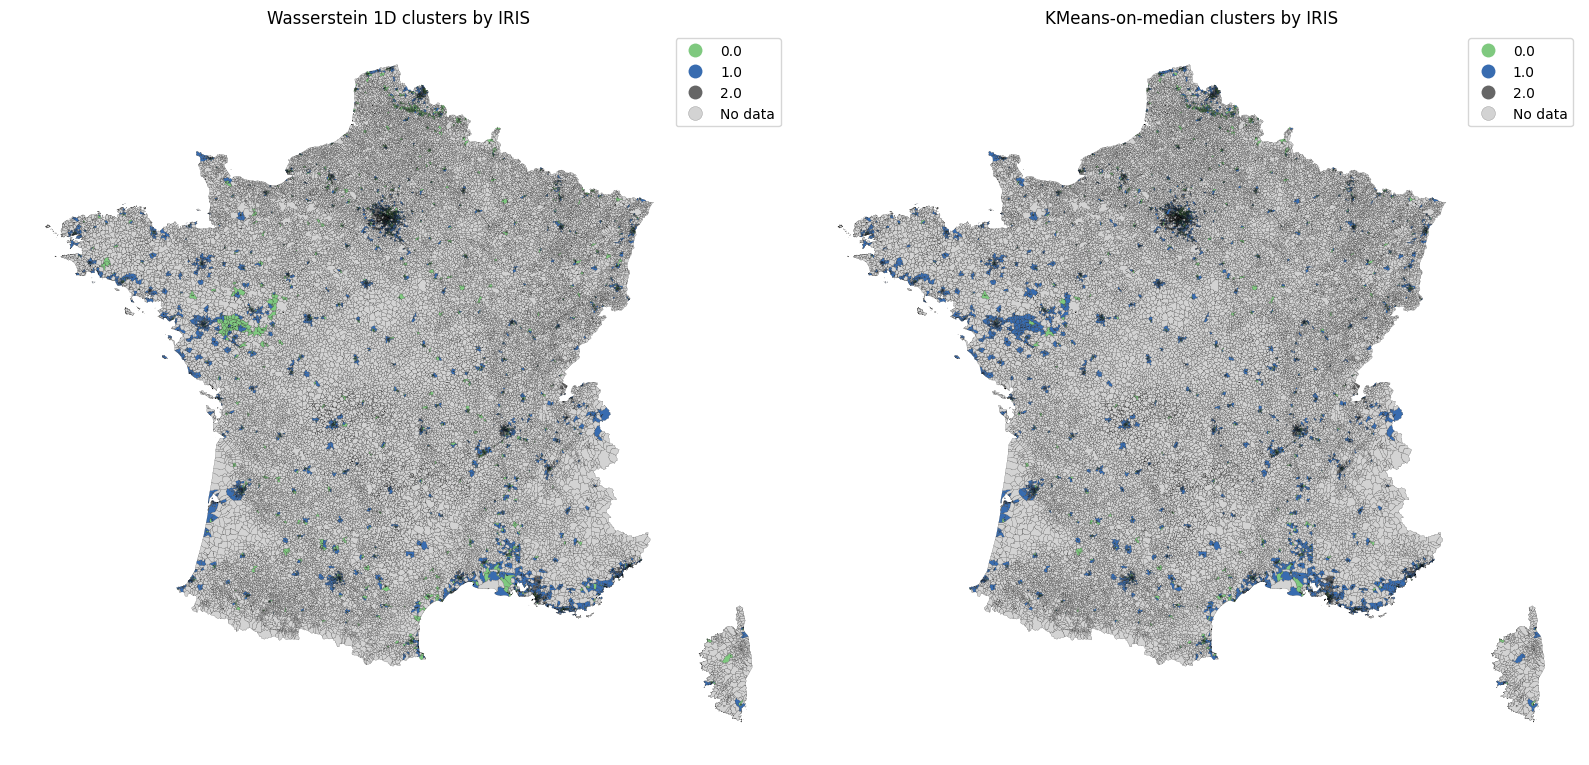

In [37]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Wasserstein clusters
gdf_france.plot(
    column='cluster_wasserstein_1d',
    cmap='Accent',
    legend=True,
    ax=axes[0],
    missing_kwds={'color': 'lightgrey', 'label': 'No data'},
    edgecolor='black',
    linewidth=0.1
)
axes[0].set_title("Wasserstein 1D clusters by IRIS")
axes[0].axis('off')

# Median KMeans clusters
gdf_france.plot(
    column='cluster_median',
    cmap='Accent',
    legend=True,
    ax=axes[1],
    missing_kwds={'color': 'lightgrey', 'label': 'No data'},
    edgecolor='black',
    linewidth=0.1
)
axes[1].set_title("KMeans-on-median clusters by IRIS")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Paris

Next, we focus on Paris, where we have higher resolution data. This will allow us to observe finer spatial patterns and variations within this densely populated area.

In [40]:
iris_paris = [iris for iris in df_clean['IRIS'] if iris.startswith("75")]

gdf_paris = gdf[gdf["code_iris"].isin(iris_paris)].copy()


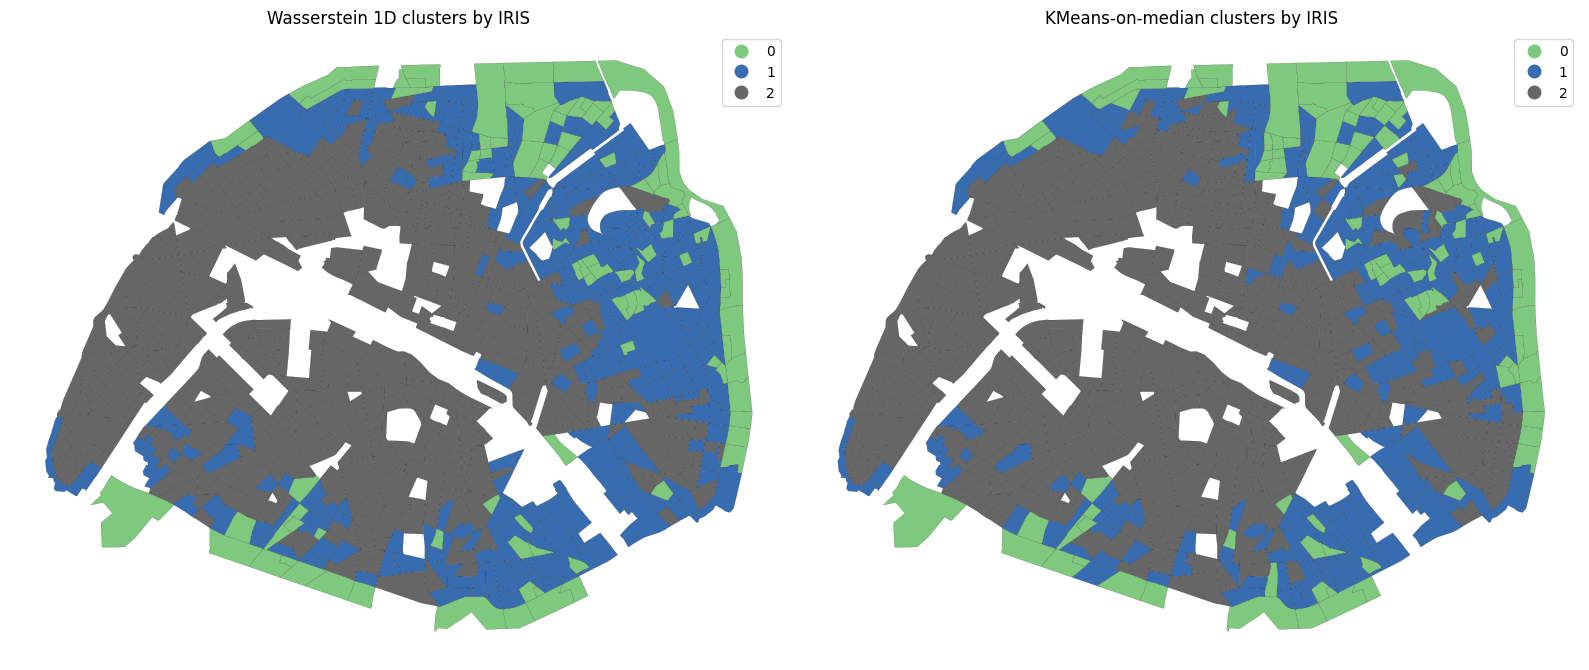

In [41]:
# Merge with clustering results
gdf_paris = gdf_paris.merge(
    df_clean[["IRIS", "cluster_wasserstein_1d", "cluster_median"]],
    left_on="code_iris",
    right_on="IRIS",
    how="left"
)

# Convert cluster labels to categorical for coloring
gdf_paris["cluster_wasserstein_1d"] = gdf_paris["cluster_wasserstein_1d"].astype("category")
gdf_paris["cluster_median"] = gdf_paris["cluster_median"].astype("category")


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Wasserstein clusters
gdf_paris.plot(
    column='cluster_wasserstein_1d',
    cmap='Accent',
    legend=True,
    ax=axes[0],
    missing_kwds={'color': 'lightgrey', 'label': 'No data'},
    edgecolor='black',
    linewidth=0.1
)
axes[0].set_title("Wasserstein 1D clusters by IRIS")
axes[0].axis('off')

# Median KMeans clusters
gdf_paris.plot(
    column='cluster_median',
    cmap='Accent',
    legend=True,
    ax=axes[1],
    missing_kwds={'color': 'lightgrey', 'label': 'No data'},
    edgecolor='black',
    linewidth=0.1
)
axes[1].set_title("KMeans-on-median clusters by IRIS")
axes[1].axis('off')

plt.tight_layout()
plt.show()


The differences between the two clusterings are almost nonexistent.